<a href="https://colab.research.google.com/github/MKalantari1993/Deep-Learning/blob/main/OCR_Model_for_Reading_Persian_Car_License_Plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mohammad Kalantari

#### Deep Learning Final Project
### OCR Model for Reading Persian Car License Plates

In [ ]:
# i = []
# while(True):
#     i.append('a')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### دریافت داده ها

In [ ]:
rm -r /content/*

In [ ]:
# !wget https://drive.google.com/file/d/1FTE58fzDlelNDhQgUPe26X-appnJOFS6/view?usp=sharing
!gdown https://drive.google.com/uc?id=1FTE58fzDlelNDhQgUPe26X-appnJOFS6

Downloading...
From: https://drive.google.com/uc?id=1FTE58fzDlelNDhQgUPe26X-appnJOFS6
To: /content/License_Plate.rar
100% 25.9M/25.9M [00:00<00:00, 106MB/s] 


In [ ]:
!unrar x -id[c,d,p,q] ./License_Plate.rar

### تعیین مسیر داده ها

In [ ]:

PicsPath = "./License Plate/Pic"
ListPath = "./License Plate/List.txt"

### فراخوانی داده ها و نمایش یک نمونه

In [ ]:
ListDF = pd.read_csv(ListPath, sep = "\t", header = None)
# len(ListDF)

Total Pics in directory:  1090


19830    15 264 ج 21
Name: 1, dtype: object

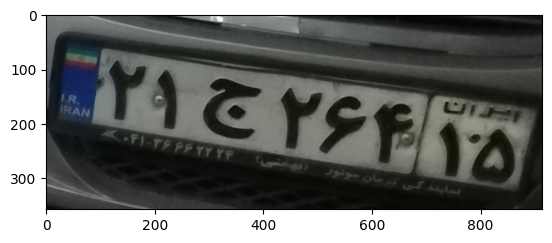

In [ ]:
total = 0
for root, dirs, files in os.walk(PicsPath):
    total += len(files)
print("Total Pics in directory: ", total)
# files
im = plt.imread(os.path.join(PicsPath, files[0]))
plt.imshow(im)
ListDF[ListDF[0]==files[0]][1]

### استخراج لیبل تصاویر

In [ ]:
from pathlib import Path

ImagesPath = Path(PicsPath)
Images = sorted(list(map(str, list(ImagesPath.glob("*.jpg")))))
ImagesNames = [img.split(os.path.sep)[-1] for img in Images]
len(ImagesNames)

1090

In [ ]:
Labels = []
for ImagesName in ImagesNames:
    Labels = Labels + list(ListDF[ListDF[0]==ImagesName][1])
len(Labels)

1090

### کنترل طول لیبل ها

In [ ]:
# Minimum and Maximum length of any label in the dataset

max_length = max([len(Label) for Label in Labels])
min_length = min([len(Label) for Label in Labels])
print(max_length, min_length)

11 11


In [ ]:
LBL = []
i = 0
for ImagesName in ImagesNames:
    LBL = list(ListDF[ListDF[0]==ImagesName][1])
    if len(LBL[0]) != 11 :
        print(ImagesName, i)
        plt.imshow(plt.imread(Images[i]))
    i += 1

### تغییر ترتیب چینش اعداد و حروف در لیبل ها مطابق با تصاویر و از چپ به راست

#### قبل از تغییر

0 8
1 8
2  
3 7
4 9
5 8
6  
7 ق
8  
9 5
10 9


'88 798 ق 59'

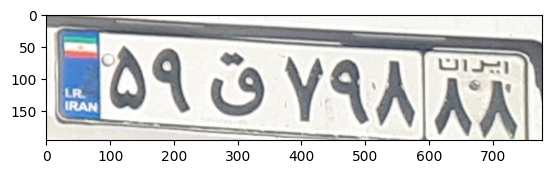

In [ ]:
# i = int(input("Please enter a number between 0 and {} ?  ".format(len(ImagesNames)-1)))
# i = int(input("Please enter a number between 0 and %i ?  "%(len(ImagesNames)-1)))
import random
rnd = random.randint(0,len(ImagesNames)-1)
plt.imshow(plt.imread(Images[rnd]))
for j in range (len (Labels[rnd])):
    print(j,Labels[rnd][j])
Labels[rnd]

#### تغییر چیدمان

In [ ]:
import tensorflow as tf
for i in range(len(Labels)):
    splt = tf.strings.unicode_split(Labels[i], input_encoding = "UTF-8")
    Labels[i] = tf.strings.reduce_join\
    ([splt[9],splt[10],splt[8],splt[7],splt[6],splt[3],splt[4],splt[5],splt[2],splt[0],splt[1]])\
    .numpy().decode("utf-8")

#### بعد از تغییر

5
9
 
ق
 
7
9
8
 
8
8


'59 ق 798 88'

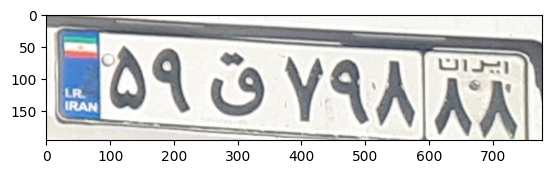

In [ ]:
# i = int(input("Please enter a number between 0 and {} ?  ".format(len(ImagesNames)-1)))
# i = int(input("Please enter a number between 0 and %i ?  "%(len(ImagesNames)-1)))
plt.imshow(plt.imread(Images[rnd]))
for j in range (len (Labels[rnd])):
    print(Labels[rnd][j])
Labels[rnd]

### پایان مرحله ی آماده سازی داده ها - شروع مرحله پردازش داده ها

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#print(tf. __version__)
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

### استخراج کاراکترهای موجود در لیبل ها

In [ ]:
Characters = set(Char for Label in Labels for Char in Label)
print("Number of unique characters: ", len(Characters))

Number of unique characters:  27


In [ ]:
Characters

{' ',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'ب',
 'ث',
 'ج',
 'د',
 'س',
 'ش',
 'ص',
 'ط',
 'ع',
 'ق',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ی'}

###  انکدینگ کاراکترها به اعداد و دیکدینگ انها

In [ ]:
# Mapping characters to integers
char_to_num = StringLookup (
    vocabulary = list(Characters), mask_token = None
)
# Mapping integers back to original characters
num_to_char = StringLookup (
    vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True
)

In [ ]:
#print(char_to_num (' ').numpy())
num_to_char(5).numpy().decode("utf-8")

'س'

### تقسیم داده های شافل شده به دو دسته ی تست و ترین

In [ ]:
# splitting data into train and test

def split_data(images, labels, train_size = 0.9, shuffle = True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
###
x_train, x_valid, y_train, y_valid = split_data(np.array(Images), np.array(Labels))

### تعریف تابع انکدینگ تصاویر به همراه خروجی لیبل مربوطه

In [ ]:
# Desired image dimensions

img_width = 200
img_height = 50

In [ ]:
# Encoding images

def encode_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels = 1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm = [1, 0, 2])

    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding = "UTF-8"))

    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

### ایجاد آبجتکت های دیتاستی تنسرفلو و مشاهده ی یک نمونه

In [ ]:
# Create Dataset objects

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

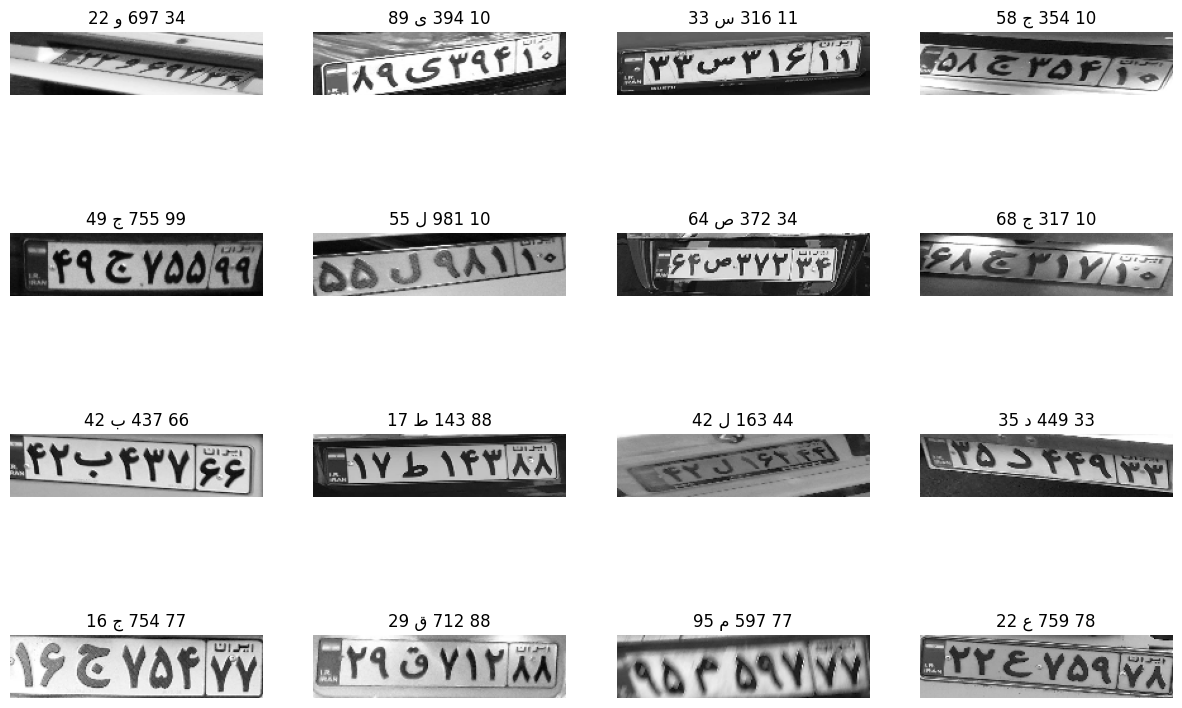

In [ ]:
# Visualize the data

_, ax = plt.subplots(4, 4, figsize=(15, 10))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### تعریف لایه ی سی تی سی و تعیین ساختار مدل و ساخت آن

In [ ]:
# Defining CTC Layer

class CTCLayer(layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        # Compute the training-time loss value and add it to the layer using self.add_loss()
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

        input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Create the Model

def build_model():

    # Inputs to the model
    input_img = layers.Input(
        shape =(img_width, img_height, 1), name = "image", dtype = "float32"
    )
    labels = layers.Input(name = "label", shape = (None,), dtype = "float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name = "pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name = "pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name = "pool3")(x)

    # Reshape accordingly before passing the output to the RNN part of the model
    downsample_factor = 8
    new_shape = ((img_width // downsample_factor), (img_height // downsample_factor) * 128)
    x = layers.Reshape(target_shape = new_shape, name = "reshape")(x)

    # ....
    x = layers.Dense(128, activation = "relu", name = "dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(256, return_sequences = True, dropout = 0.25))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True, dropout = 0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation = "softmax", name = "dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name = "ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs = [input_img, labels], outputs = output, name = "ocr_model_v1"
    )

    # Compile the model
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer = opt)

    # Return
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

### آموزش مدل

In [ ]:
# tf.test.is_gpu_available() # True/False
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Training

# Add early stopping
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = early_stopping_patience, restore_best_weights = True
)

# Train the model
epochs = 250
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    # callbacks = [early_stopping],
)

Epoch 1/250
62/62 [==============================] - 32s 97ms/step - loss: 35.5708 - val_loss: 30.3683
Epoch 2/250
62/62 [==============================] - 3s 41ms/step - loss: 29.5590 - val_loss: 28.7605
Epoch 3/250
62/62 [==============================] - 3s 56ms/step - loss: 28.3517 - val_loss: 27.8895
Epoch 4/250
62/62 [==============================] - 3s 56ms/step - loss: 27.5268 - val_loss: 27.2108
Epoch 5/250
62/62 [==============================] - 3s 41ms/step - loss: 26.8769 - val_loss: 26.5151
Epoch 6/250
62/62 [==============================] - 3s 43ms/step - loss: 26.2750 - val_loss: 25.9455
Epoch 7/250
62/62 [==============================] - 4s 58ms/step - loss: 25.7039 - val_loss: 25.3226
Epoch 8/250
62/62 [==============================] - 3s 43ms/step - loss: 25.1613 - val_loss: 24.8609
Epoch 9/250
62/62 [==============================] - 3s 41ms/step - loss: 24.6346 - val_loss: 24.2205
Epoch 10/250
62/62 [==============================] - 3s 40ms/step - loss: 24.177

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#model.save('/content/drive/MyDrive/trained_model')

### تست مدل

In [ ]:
# !gdown https://drive.google.com/uc?id=1c-xkkWH1YGrOYnXqFgImji88Kz1c-zIv
# !unzip my_model.zip
# pretrained_model = keras.models.load_model('/content/my_model')

In [ ]:
# Get the Prediction Model

# Use the current trained model for inference
prediction_model = keras.models.Model(model.get_layer(name = "image").input, model.get_layer(name = "dense2").output)
prediction_model.summary()

# # Or... use the pretrained model for inference
# prediction_model = keras.models.Model(pretrained_model.get_layer(name = "image").input, pretrained_model.get_layer(name = "dense2").output)
# prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 25, 6, 128)        0     

In [ ]:
# Decode the output of the Prediction Model
max_length = max([len(Label) for Label in Labels]) # Maximum length of any label in the dataset

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 0s 32ms/step


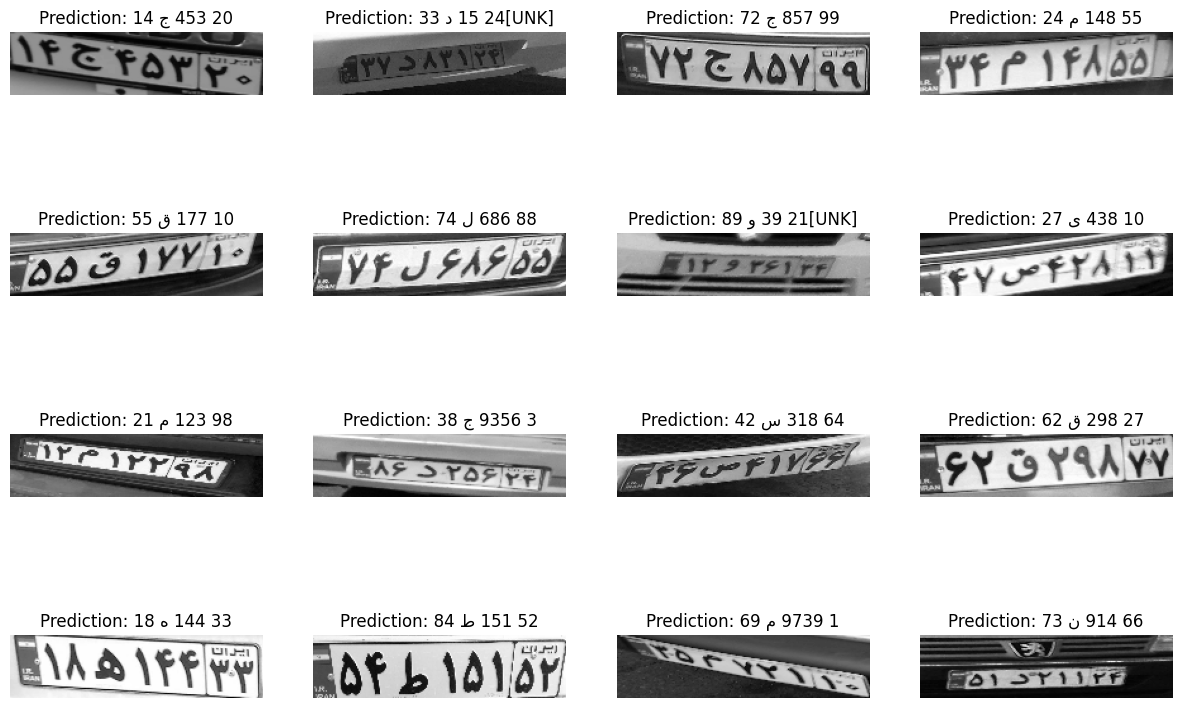

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

#     orig_texts = []
#     for label in batch_labels:
#         label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
#         orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize = (15,10))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()